# Relax Challenge

This project challenge provided two CSV files, *'takehome_users.cvs'* and *'takehome_user_engagement.csv'*. The *'takehome_users.csv'* file contains 12000 users (and 10 columns) who signed up for the product in the last two years. The *'takehome_user_engagement.csv'* file describes the usage summary, which is a row for each day that a user logged into the product.

<span style="color:navy">
    <b>Instructions</b>: Define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, and identify which factors predict future user adoption. Please send us a brief writeup of your findings (the more concise, the better, with no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.
</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import ydata_profiling

In [3]:
user_df = pd.read_csv(".\\data\\takehome_users.csv", encoding='latin-1')
usage_df = pd.read_csv(".\\data\\takehome_user_engagement.csv")

## Data

### User table

In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Two columns have missing values, `last_session_creation_time` and `invited_by_user_id`.

Some quick data wrangling to be addressed:
- object_id: nunique == 12000? and understand range
- creation_time: to datetime and check range
- creation_source: value_counts and to category
- last_session_creation_time: to unix timestamp or datetime; how to impute? Can we use the usage_df?
- opted_in_to_mailing_list: value_counts
- enabled_for_marketing_drip: value_counts
- org_id: check range
- invited_by_user_id: not int64? Missing probably means not invited, so fill with a value not in object_id

In [6]:
user_df['object_id'].nunique()

12000

In [7]:
user_df['object_id'].describe()

count    12000.00000
mean      6000.50000
std       3464.24595
min          1.00000
25%       3000.75000
50%       6000.50000
75%       9000.25000
max      12000.00000
Name: object_id, dtype: float64

In [8]:
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])

In [9]:
user_df['creation_time'].describe()

count                            12000
mean     2013-07-16 13:25:32.964499968
min                2012-05-31 00:43:27
25%      2013-01-15 21:28:22.750000128
50%         2013-08-05 21:35:19.500000
75%      2014-01-28 10:20:12.249999872
max                2014-05-30 23:59:19
Name: creation_time, dtype: object

In [10]:
user_df['creation_source'].value_counts()

creation_source
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: count, dtype: int64

In [11]:
user_df['creation_source'] = user_df['creation_source'].astype('category')

In [12]:
user_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                     category
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [13]:
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'], unit='s')

In [14]:
user_df['last_session_creation_time'].describe()

count                             8823
mean     2013-09-15 21:08:25.700441856
min                2012-05-31 08:20:06
25%                2013-03-13 17:16:05
50%                2013-10-27 15:41:10
75%                2014-04-25 16:16:44
max                2014-06-06 14:58:50
Name: last_session_creation_time, dtype: object

In [15]:
user_df['opted_in_to_mailing_list'].value_counts()

opted_in_to_mailing_list
0    9006
1    2994
Name: count, dtype: int64

In [16]:
user_df['enabled_for_marketing_drip'].value_counts()

enabled_for_marketing_drip
0    10208
1     1792
Name: count, dtype: int64

In [17]:
user_df['org_id'].describe()

count    12000.000000
mean       141.884583
std        124.056723
min          0.000000
25%         29.000000
50%        108.000000
75%        238.250000
max        416.000000
Name: org_id, dtype: float64

In [18]:
user_df['org_id'].value_counts().head(10)

org_id
0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
Name: count, dtype: int64

In [19]:
user_df[((user_df['invited_by_user_id'] % 1) != 0)]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
10,11,2013-12-26 03:55:54,Paulsen Malthe,MaltheAPaulsen@gustr.com,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN
13,14,2012-10-11 16:14:33,Rivera Bret,BretKRivera@gmail.com,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaT,0,0,281,NaN
11994,11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,2013-10-22 13:33:17,0,0,0,NaN
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN


That number of rows matches the number of null values for `invited_by_user_id`, so our dtype is a float because of the nan.

In [20]:
user_df[((user_df['invited_by_user_id'] % 1) != 0) & ~user_df['invited_by_user_id'].isna()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [21]:
user_df.fillna({'invited_by_user_id':0}, inplace=True)

In [22]:
user_df['invited_by_user_id'].describe()

count    12000.000000
mean      3188.691333
std       3869.027693
min          0.000000
25%          0.000000
50%        875.000000
75%       6317.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

In [23]:
user_df[((user_df['invited_by_user_id'] % 1) != 0)]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [24]:
user_df['invited_by_user_id'] = user_df['invited_by_user_id'].astype('int64')

In [25]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  category      
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int64         
dtypes: category(1), datetime64[ns](2), int64(5), object(2)
memory usage: 855.8+ KB


### Usage table

In [26]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [27]:
usage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [28]:
usage_df['time_stamp'] = pd.to_datetime(usage_df['time_stamp'])

In [29]:
usage_df['time_stamp'].nunique()

207220

In [30]:
usage_df.value_counts(subset=['time_stamp', 'user_id'])

time_stamp           user_id
2012-05-31 08:20:06  10012      1
2014-02-10 13:58:55  2727       1
2014-02-10 13:22:10  8789       1
2014-02-10 13:23:57  9402       1
2014-02-10 13:29:52  7179       1
                               ..
2013-09-07 16:30:52  63         1
2013-09-07 16:32:48  8767       1
2013-09-07 16:43:10  9582       1
2013-09-07 16:43:37  7707       1
2014-06-06 14:58:50  4051       1
Name: count, Length: 207917, dtype: int64

In [31]:
print(usage_df['user_id'].min(), usage_df['user_id'].max())

1 12000


In [32]:
usage_df['visited'].value_counts()

visited
1    207917
Name: count, dtype: int64

## Adopted users

To define an adopted user, we have to see if they have logged into the product on 3 separate days in at least one seven-day period.

In [33]:
def is_adopted(uid):
    """
    Determines whether a user is adopted or not. An adopted user is one who has logged into the product on three separate
    days in at least one seven-day period.
    
    uid : the user ID, which should exist in the usage_df as 'user_id' and in the user_df as 'object_id'
    """
    user_times = usage_df[usage_df['user_id'] == uid]['time_stamp'].sort_values(ascending=True).reset_index(drop=True)
    if len(user_times) < 3:
        # fails minimum requirement of 3 days of logins
        return False
    # check if they have a 7-day window where they logged in 3 days
    for i in range(0, len(user_times)):
        if (i + 2) < len(user_times):
            # ith, i+1, and i+2 must be acceptable indices
            week_later = user_times[i] + pd.Timedelta(7, 'd')
            # check if this time and next 2 times are within 1 week from this time
            if (user_times[i] <= week_later) \
                & (user_times[i+1] <= week_later) \
                & (user_times[i+2] <= week_later):
                    return True
    return False

In [34]:
adopted = []
for uid in range(1, user_df['object_id'].max() + 1):
    adopted.append(is_adopted(uid))

In [35]:
len(adopted)

12000

In [36]:
user_df['adopted'] = adopted

In [37]:
user_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,False
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,False
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,False
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,True


In [38]:
user_df[user_df['adopted'].isna()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted


In [39]:
print(len(user_df[user_df['adopted'] == True]))
print(len(user_df[user_df['adopted'] == True])/len(user_df))

1656
0.138


Unsurprisingly, we have a moderately imbalanced dataset, where the number of `adopted` users is 1656 (13.8%).

## Missing last session

First, the `usage_df` will be used to verify that the user has not logged in recently. If we cannot find the user, then we will just fill the missing values with the first session (the `creation_time`).

In [40]:
missing_last_indices = list(user_df[user_df['last_session_creation_time'].isna()].index)

In [41]:
dne_counter = 0
user_set = set(usage_df['user_id'])
for i in missing_last_indices:
    if (i+1) in user_set:
        print("Found:", i)
    else:
        dne_counter += 1

if (dne_counter == len(missing_last_indices)):
    print("No indices found.")

No indices found.


In [42]:
for i in missing_last_indices:
    user_df.loc[i,'last_session_creation_time'] = user_df.loc[i,'creation_time']

In [43]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  category      
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int64         
 10  adopted                     12000 non-null  bool          
dtypes: bool(1), category(1), datetime64[ns](2), int64(5), 

## Quick EDA

In [44]:
report = user_df.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

## Preprocessing and Modeling

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample

from sklearn.inspection import permutation_importance

%matplotlib inline

### Encode categories

In [46]:
user_df['opted_in_to_mailing_list'] = user_df['opted_in_to_mailing_list'].astype('bool')
user_df['enabled_for_marketing_drip'] = user_df['enabled_for_marketing_drip'].astype('bool')

In [47]:
user_df_enc = pd.get_dummies(user_df, columns=['creation_source'])
user_df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           12000 non-null  int64         
 1   creation_time                       12000 non-null  datetime64[ns]
 2   name                                12000 non-null  object        
 3   email                               12000 non-null  object        
 4   last_session_creation_time          12000 non-null  datetime64[ns]
 5   opted_in_to_mailing_list            12000 non-null  bool          
 6   enabled_for_marketing_drip          12000 non-null  bool          
 7   org_id                              12000 non-null  int64         
 8   invited_by_user_id                  12000 non-null  int64         
 9   adopted                             12000 non-null  bool          
 10  creation_source_GUEST_

In [48]:
drop_cols = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time']
X = user_df_enc.drop(columns=drop_cols + ['adopted'])
y = user_df_enc['adopted']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

In [50]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
lr_clf.score(X_test, y_test)

0.8594444444444445

Since our class is imbalanced, we must check the actual predictions. If our predictions are poor, we can try downsampling (a downsample by a factor of 6 would get us 51/49 split) or we can try adjusting the threshold for the probabilities.

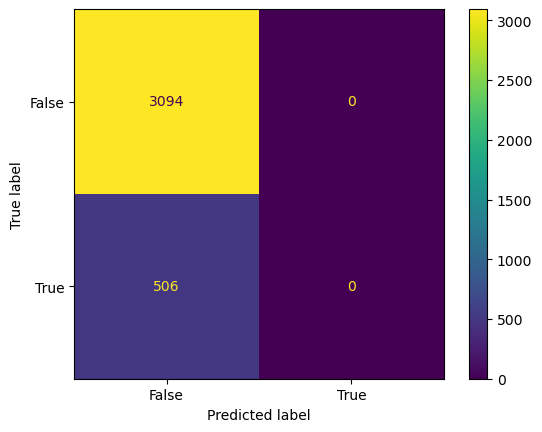

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Resampled dataset

In [52]:
adopted1_df = user_df_enc[user_df_enc['adopted'] == True]
adopted0_df = user_df_enc[user_df_enc['adopted'] == False]
print(adopted1_df.shape, adopted0_df.shape)

(1656, 15) (10344, 15)


In [53]:
DOWNSAMPLE_FACTOR = 6
DOWNSAMPLED_LENGTH = int(len(adopted0_df)/DOWNSAMPLE_FACTOR)
print(f"{len(adopted0_df)} / {DOWNSAMPLE_FACTOR} = {DOWNSAMPLED_LENGTH}")

10344 / 6 = 1724


In [54]:
adopted0_df_down = resample(adopted0_df, replace=True, n_samples=DOWNSAMPLED_LENGTH, random_state=23)
print(adopted0_df_down.shape)

(1724, 15)


In [55]:
downsampled_df = pd.concat([adopted1_df, adopted0_df_down])
downsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3380 entries, 1 to 5174
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   object_id                           3380 non-null   int64         
 1   creation_time                       3380 non-null   datetime64[ns]
 2   name                                3380 non-null   object        
 3   email                               3380 non-null   object        
 4   last_session_creation_time          3380 non-null   datetime64[ns]
 5   opted_in_to_mailing_list            3380 non-null   bool          
 6   enabled_for_marketing_drip          3380 non-null   bool          
 7   org_id                              3380 non-null   int64         
 8   invited_by_user_id                  3380 non-null   int64         
 9   adopted                             3380 non-null   bool          
 10  creation_source_GUEST_INVITE 

In [56]:
len(downsampled_df[downsampled_df['adopted']==True])

1656

In [57]:
drop_cols = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time']
X_ds = downsampled_df.drop(columns=drop_cols + ['adopted'])
y_ds = downsampled_df['adopted']

In [58]:
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X_ds, y_ds, test_size=0.30, random_state=23)

0.5680473372781065
0.5581854043392505
0.5637450199203187


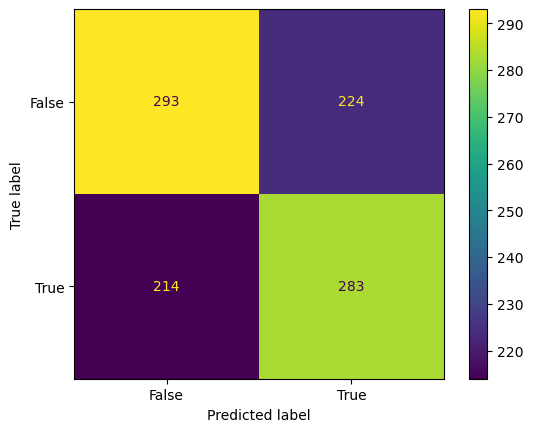

In [59]:
lr_clf_ds = LogisticRegression(random_state=23)
lr_clf_ds = lr_clf.fit(X_train_ds, y_train_ds)
y_pred_ds = lr_clf.predict(X_test_ds)
print(lr_clf_ds.score(X_test_ds, y_test_ds))
print(precision_score(y_test_ds, y_pred_ds))
print(f1_score(y_test_ds, y_pred_ds))
ConfusionMatrixDisplay.from_predictions(y_test_ds, y_pred_ds)

We lost a lot of False accuracy, but we now are predicting some True.

In [60]:
def get_gridCV(estimator, param_grid, X_train, y_train):
    """
    GridSearchCV for an estimator using the paramater grid, X_train, and y_train.
    """
    gridCV = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=['accuracy', 'precision', 'f1'], refit='f1', n_jobs=-1)
    gridCV.fit(X_train, y_train)
    return gridCV

In [61]:
lr_params = {
    'solver': ['liblinear', 'lbfgs', 'newton-cholesky'],
    'class_weight': [None, 'balanced']
}
dslr_gridCV = get_gridCV(LogisticRegression(penalty='l2', random_state=23), lr_params, X_train_ds, y_train_ds)

In [62]:
pd.DataFrame(dslr_gridCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.016263,0.004653,0.047323,0.017539,None,liblinear,"{'class_weight': None, 'solver': 'liblinear'}",0.594937,0.591966,0.572939,...,0.011888,2,0.594937,0.588486,0.568376,0.568928,0.572025,0.578550,0.011008,3
1,0.036698,0.017783,0.011363,0.003919,None,lbfgs,"{'class_weight': None, 'solver': 'lbfgs'}",0.567511,0.581395,0.575053,...,0.015778,1,0.501217,0.580508,0.515663,0.525060,0.555085,0.535506,0.028591,6
2,0.010976,0.002765,0.016623,0.004177,None,newton-cholesky,"{'class_weight': None, 'solver': 'newton-chole...",0.594937,0.591966,0.572939,...,0.012866,3,0.594937,0.588486,0.566524,0.565789,0.566038,0.576355,0.012706,4
3,0.011375,0.001150,0.012578,0.001770,balanced,liblinear,"{'class_weight': 'balanced', 'solver': 'liblin...",0.590717,0.583510,0.575053,...,0.012404,6,0.607287,0.598778,0.592292,0.597510,0.567901,0.592754,0.013327,2
4,0.018949,0.004231,0.010581,0.001623,balanced,lbfgs,"{'class_weight': 'balanced', 'solver': 'lbfgs'}",0.580169,0.579281,0.579281,...,0.016276,4,0.540416,0.593047,0.550790,0.581590,0.559006,0.564970,0.019515,5
5,0.010772,0.002631,0.009995,0.001086,balanced,newton-cholesky,"{'class_weight': 'balanced', 'solver': 'newton...",0.590717,0.585624,0.577167,...,0.012511,5,0.608871,0.600000,0.593496,0.595833,0.567901,0.593220,0.013703,1


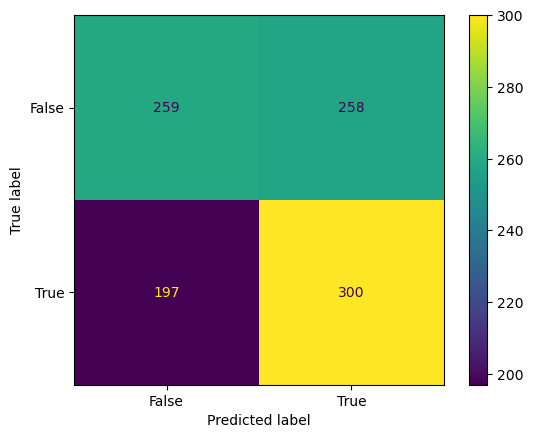

In [63]:
ConfusionMatrixDisplay.from_estimator(dslr_gridCV.best_estimator_, X_test_ds, y_test_ds)

In [64]:
rf_params = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 150, 200],
    'class_weight': [None, 'balanced', {False:6,True:1}]
}
dsrf_gridCV = get_gridCV(RandomForestClassifier(max_features=1.0, random_state=23, n_jobs=-1), rf_params, X_train_ds, y_train_ds)

In [65]:
pd.DataFrame(dsrf_gridCV.cv_results_).sort_values('rank_test_f1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,...,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
11,2.652737,0.212285,0.905522,0.315845,balanced,entropy,200,"{'class_weight': 'balanced', 'criterion': 'ent...",0.546414,0.600423,...,0.027426,2,0.531590,0.580931,0.523810,0.557940,0.525862,0.544027,0.022131,1
5,2.444549,0.315519,0.967113,0.464907,None,entropy,200,"{'class_weight': None, 'criterion': 'entropy',...",0.535865,0.598309,...,0.028561,1,0.523810,0.577778,0.518681,0.569593,0.523810,0.542734,0.025473,2
14,2.186547,0.229686,0.945567,0.360089,"{False: 6, True: 1}",gini,200,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.521097,0.583510,...,0.025132,11,0.507592,0.568928,0.541126,0.565957,0.522484,0.541217,0.023923,3
13,1.708710,0.344526,0.888430,0.398392,"{False: 6, True: 1}",gini,150,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.518987,0.591966,...,0.027641,8,0.504348,0.581345,0.530973,0.562900,0.520430,0.539999,0.028176,4
12,1.601455,0.526299,0.540685,0.279279,"{False: 6, True: 1}",gini,100,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.523207,0.596195,...,0.029457,9,0.506550,0.585683,0.529540,0.559140,0.515021,0.539187,0.029333,5
9,1.722762,0.222342,0.569169,0.211768,balanced,entropy,100,"{'class_weight': 'balanced', 'criterion': 'ent...",0.540084,0.600423,...,0.030297,5,0.530172,0.580931,0.519651,0.551724,0.510823,0.538660,0.025163,6
17,2.512683,0.053107,0.321107,0.271503,"{False: 6, True: 1}",entropy,200,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.527426,0.594080,...,0.025646,3,0.508772,0.575221,0.533040,0.549356,0.521739,0.537626,0.023052,7
16,1.866534,0.331651,0.941910,0.343647,"{False: 6, True: 1}",entropy,150,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.514768,0.602537,...,0.031568,4,0.488889,0.591304,0.537445,0.551724,0.515284,0.536929,0.034503,8
2,2.160278,0.150348,0.890453,0.237052,None,gini,200,"{'class_weight': None, 'criterion': 'gini', 'n...",0.546414,0.596195,...,0.030851,12,0.537634,0.580220,0.505495,0.554839,0.505400,0.536717,0.028905,9
15,1.574839,0.268162,0.689030,0.318722,"{False: 6, True: 1}",entropy,100,"{'class_weight': {False: 6, True: 1}, 'criteri...",0.523207,0.596195,...,0.028674,6,0.502203,0.583878,0.529801,0.554839,0.509804,0.536105,0.030047,10


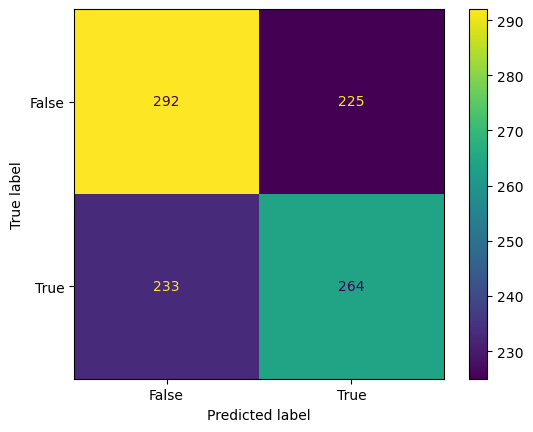

In [66]:
ConfusionMatrixDisplay.from_estimator(dsrf_gridCV.best_estimator_, X_test_ds, y_test_ds)

## Interpretation

Despite that work, the default LogisticRegression model seemed to produce the nicest ConfusionMatrix. Bringing it back down here...

Accuracy:  0.5680473372781065
Precision:  0.5581854043392505
F1:  0.5637450199203187


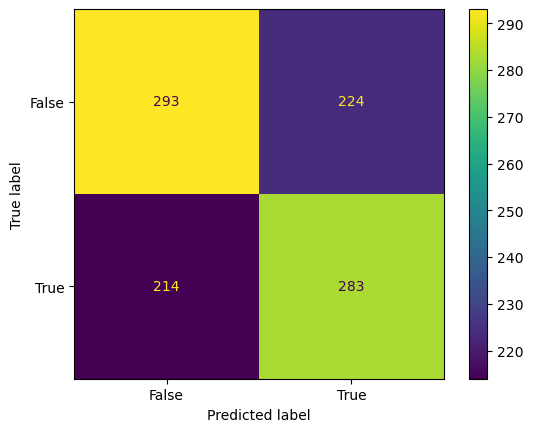

In [67]:
lr_clf_ds = LogisticRegression(random_state=23)
lr_clf_ds = lr_clf.fit(X_train_ds, y_train_ds)
y_pred_ds = lr_clf.predict(X_test_ds)
print("Accuracy: ", lr_clf_ds.score(X_test_ds, y_test_ds))
print("Precision: ", precision_score(y_test_ds, y_pred_ds))
print("F1: ", f1_score(y_test_ds, y_pred_ds))
_ = ConfusionMatrixDisplay.from_predictions(y_test_ds, y_pred_ds)
plt.show()

In [68]:
result = permutation_importance(lr_clf_ds, X_test_ds, y_test_ds, n_repeats=20, random_state=23)
perm_imps = pd.Series(result.importances_mean, index=lr_clf_ds.feature_names_in_)

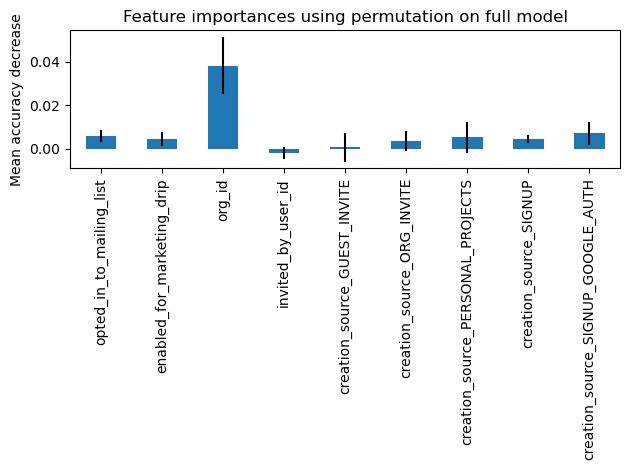

In [69]:
fig, ax = plt.subplots()
perm_imps.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

The `org_id` was found to be the most important for this model.

## Conclusion and Future Work

The model is far from perfect; the dataset imbalance is probably still too detrimental. This model found that the `org_id` and `creation_source` being 'SIGNUP_GOOGLE_AUTH' were the most important features. I do not completely understand what `creation_source` means, but I speculate that having a convenient way to sign up was important for the user to sign up and continue signing in. The `org_id` could make sense because it means that they may use this for some kind of work or group, and so there may be a social, educational, or work incentive to continue logging in often.

We could attempt to adjust further to the class imbalance. For example, we did not explore the other alternative I mentioned above, which was to tune the threshold of our probabilities to the classes. The class weights may be adjusted too. Completely different models could also be tried, as we only used two relatively basic ones (logistic regression and random forest classifier). Otherwise, more work could be done with feature engineering, since we used just the data given. For examples... Would it be helpful to generalize the `org_id`, `invited_by_user_id`, and `creation_source`? Should the dates be considered somehow, such as in the forms of login frequencies or raw total logins? More experimentation can be done, but this project had a roughly 2-hour time limit, so I will end with what I have here.